In [43]:
from gensim.models import KeyedVectors
from time import time 


# load de vectors with gensim 
tic = time()
word_vectors_fpath = "model/cc.de.300.word_vectors"
wv = KeyedVectors.load_word2vec_format(word_vectors_fpath, binary=False, unicode_errors="ignore")
print("Loaded in {} sec.".format(time()-tic))

# target words = Maus, Schlange

# iteratively subtract until the norm is not ...

# show the prorotypes (by printing their nns)



Loaded in 440.9788191318512 sec.


In [47]:
# save the model in the gensim format to load it fast again
de_gensim_fpath = "model/cc.de.300.word_vectors.gensim"

tic = time()
wv.save(de_gensim_fpath)
print("Saved in {} sec.".format(time()-tic))



Saved in 5.936842918395996 sec.


In [49]:
from gensim.models import Word2Vec

# load the model 

tic = time()
wvg = Word2Vec.load(de_gensim_fpath)
print("Loaded in {} sec.".format(time()-tic))

AttributeError: 'EuclideanKeyedVectors' object has no attribute 'negative'

In [ ]:
import re


first_not_letter = re.compile(r"^[^a-z]",re.IGNORECASE)
last_not_letter = re.compile(r"[^a-z]$", re.IGNORECASE)


def minimize(word):
    word = word.strip().lower()

    if first_not_letter.findall(word):
        word = word[1:]

    if last_not_letter.findall(word):
        word = word[:-1]

    return word



In [168]:
pairs

{('-Mäuse', 'Mauszeiger'),
 ('2-Maus', 'Katz'),
 ('3-Tasten', 'Katz'),
 ('3-Tasten-Maus', 'Katz'),
 ('360-Controller', 'Katz'),
 ('3D-Maus', 'Katz'),
 ('Babymaus', 'Mauszeiger'),
 ('Babymaus', 'WASD'),
 ('Babymaus', 'Zeigegerät'),
 ('Babymaus', 'Zeigegeräte'),
 ('Bildermaus', 'USB-Maus'),
 ('Bildschirm-Tastatur', 'Katz'),
 ('Bildschirmecke', 'Mäuse'),
 ('Bluetooth-Maus', 'Katz'),
 ('Bluetooth-Maus', 'Wellmich'),
 ('CTRL-Taste', 'Mäuse'),
 ('Computermaus', 'Ferkel'),
 ('Computermaus', 'Pfeilchen'),
 ('Curser', 'Mäuse'),
 ('Cursor', 'Mäuse'),
 ('Cursorsteuerung', 'Mäuschen'),
 ('Cursortaste', 'Mäuse'),
 ('Cursortasten', 'Katz'),
 ('Daumentasten', 'Feldmaus'),
 ('DeathAdder', 'Mauszeiger'),
 ('E-Taste', 'Mäuse'),
 ('Eichhörnchen', 'Mausbedienung'),
 ('Eingabegerät', 'Katz'),
 ('Erdmaus', 'WASD'),
 ('Eule', 'PC-Maus'),
 ('Feldmaus', 'Joystick'),
 ('Feldmaus', 'Mausrad'),
 ('Feldmaus', 'Seitentasten'),
 ('Feldmaus', 'SpaceMouse'),
 ('Feldmaus', 'Trackballs'),
 ('Ferkel', 'Funk-Tastatur'),
 

In [169]:
# from word_sense_induction import minimize 

from chinese_whispers import chinese_whispers, aggregate_clusters
from networkx import Graph

TOPN = 50
verbose = True
# load the wv here as a global variable ...


def get_nns(target, topn=TOPN):
    nns = wv.most_similar(positive=[target], negative=[], topn=topn)
    nns = [(word, score) for word, score in nns if minimize(word) != minimize(target)]
    return nns


def in_nns(nns, word):
    for w, s in nns:
        if minimize(word) == minimize(w):
            return True
        
    return False 


def get_pair(first, second):
    pair_lst = sorted([first, second])
    sorted_pair = (pair_lst[0], pair_lst[1])
    return sorted_pair         


def get_disc_pairs(ego, topn=TOPN):  
    pairs = set()
    nns = get_nns(ego, topn)
    
    for i in range(len(nns)):
        topi = nns[i][0]
        nns_topi = get_nns(topi, topn) 
        nns_untopi = wv.most_similar(positive=[ego], negative=[topi], topn=topn)
        untopi = nns_untopi[0][0]
        if in_nns(nns, untopi): pairs.add(get_pair(topi, untopi))

    return pairs


def get_nodes(pairs):
    nodes = set()
    for src, dst in pairs:
        nodes.add(src)
        nodes.add(dst)
        
    return nodes


def foo(ego, topn=TOPN):
    pairs = get_disc_pairs(ego, topn)
    nodes = get_nodes(pairs)
    
    return pairs, nodes


def list2dict(lst):
    return {p[0]: p[1] for p in lst}


def wsi(ego, topn=TOPN):
    tic = time()
    ego_network = Graph(name=ego)

    pairs = get_disc_pairs(ego, topn)
    nodes = get_nodes(pairs)   
    ego_network.add_nodes_from(nodes)

    for r_node in ego_network:
        related_related_nodes = list2dict(get_nns(r_node))
        related_related_nodes_ego = sorted(
            [(related_related_nodes[rr_node], rr_node) for rr_node in related_related_nodes if rr_node in ego_network],
            reverse=True)[:topn]
        
        related_edges = []
        for w, rr_node in related_related_nodes_ego:
            if get_pair(r_node, rr_node) not in pairs:
                related_edges.append( (r_node, rr_node, {"weight": w}) )
            else:
                print("Skipping:", r_node, rr_node)
        ego_network.add_edges_from(related_edges)

    chinese_whispers(ego_network, weighting="top", iterations=20)
    if verbose: print("{}\t{:f} sec.".format(ego, time()-tic))

    return ego_network


m = wsi("Maus")
s = wsi("Schlange")

Maus	6.557712 sec.
Skipping: Menschenschlange Würgeschlange
Schlange	6.932058 sec.


In [156]:
%matplotlib inline

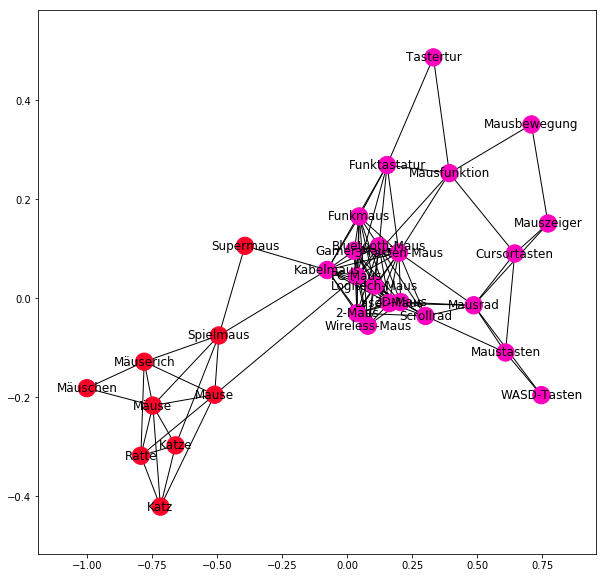

In [166]:
import networkx as nx
import matplotlib.pyplot as plt

G = m

colors = [1. / G.node[node]['label'] for node in G.nodes()]

fig = plt.gcf()
fig.set_size_inches(10, 10)

nx.draw_networkx(G, cmap=plt.get_cmap('gist_rainbow'), node_color=colors, font_color='black')

plt.show()

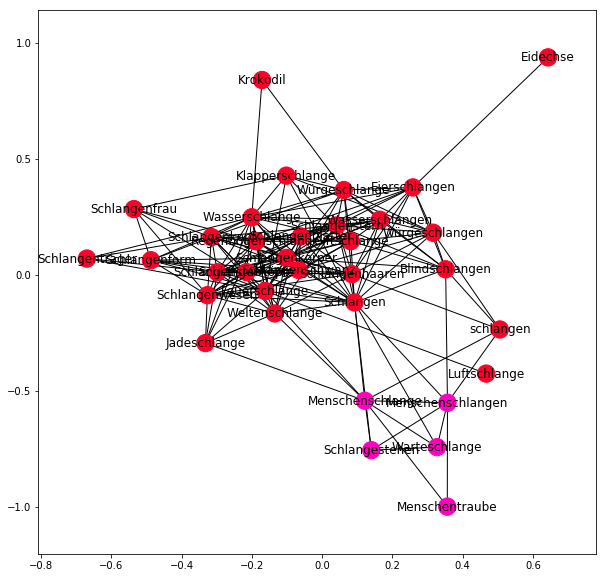

In [170]:
import networkx as nx
import matplotlib.pyplot as plt

G = s

colors = [1. / G.node[node]['label'] for node in G.nodes()]

fig = plt.gcf()
fig.set_size_inches(10, 10)

nx.draw_networkx(G, cmap=plt.get_cmap('gist_rainbow'), node_color=colors,
                 font_color='black')

plt.show()

In [172]:
G = m
print('Cluster ID\tCluster elements\n')
for label, cluster in sorted(aggregate_clusters(G).items(), key=lambda e: len(e[1]), reverse=True):
    print('{}\t{}\n'.format(label, cluster))


Cluster ID	Cluster elements

13	{'2-Maus', 'Kabelmaus', 'Cursortasten', 'Laser-Maus', 'Funktastatur', 'Wireless-Maus', '3D-Maus', 'Mauszeiger', 'Gamer-Maus', 'WASD-Tasten', 'Mausbewegung', 'Tastertur', 'Bluetooth-Maus', '3-Tasten-Maus', 'Scrollrad', 'Funkmaus', 'Maustasten', 'PC-Maus', 'Mausfunktion', 'Mausrad', 'Logitech-Maus'}

7	{'Mäuse', 'Katze', 'Mäuschen', 'Katz', 'Mause', 'Supermaus', 'Spielmaus', 'Mäuserich', 'Ratte'}



In [173]:
G = s
print('Cluster ID\tCluster elements\n')
for label, cluster in sorted(aggregate_clusters(G).items(), key=lambda e: len(e[1]), reverse=True):
    print('{}\t{}\n'.format(label, cluster))



Cluster ID	Cluster elements

30	{'Weltenschlange', 'Eidechse', 'Giftschlange', 'Schlangenstab', 'Schlangenfrau', 'Feuerschlange', 'Schlangenkopf', 'Schlangen', 'Wasserschlangen', 'Wasserschlange', 'Krokodil', 'Schlangenblätter', 'schlangen', 'Würgeschlangen', 'Luftschlange', 'Schlangenköpfe', 'Schlangenschwanz', 'Schlangenform', 'Schlangenkörper', 'Eierschlangen', 'Schlangenwesen', 'Regenbogenschlange', 'Klapperschlange', 'Blindschlangen', 'Würgeschlange', 'Schlangenstern', 'Schlangenträger', 'Schlangenhaaren', 'Jadeschlange'}

29	{'Warteschlange', 'Menschenschlangen', 'Schlangestehen', 'Menschenschlange', 'Menschentraube'}



In [ ]:
 
p_m, n_m = foo("Maus")
p_s, n_s = foo("Schlange")
print(len(p_m), len(n_m))
print(len(p_s), len(n_s))
print(p_m)
print(n_m)
print(p_s)
print(n_s)

In [56]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
